# Cleaning up Data

Goals:

* Load multiple CSVs with glob
* Examine columns and types
* Create a function
* Refactor to ease reading
* Fix lambda/comprehension issue

Data license:
...that any publications resulting from the use of the data include the 
names of the principal investigator responsible for the data collection
at each institution.  They would be:

 1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
 2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
 3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
 4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation:
Robert Detrano, M.D., Ph.D.

In [1]:
# https://archive.ics.uci.edu/ml/datasets/heart+disease
import numpy as np
import pandas as pd
import polars as pl
import glob

In [2]:
def read_file(file: str, names: list[str], sep=",") -> pd.DataFrame:
    return pd.read_csv(
        file, sep=sep, names=names, dtype_backend="pyarrow", engine="pyarrow"
    )

In [3]:
def read_file_pl(file: str, names: list[str], sep=",") -> pl.DataFrame:
    return pl.read_csv(
        file,
        separator=sep,
        has_header=False,
        new_columns=names,
        infer_schema_length=None,
    )

In [4]:
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
         'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

files = glob.glob('data/processed*.data')
df = pd.concat([read_file(f, names=names) for f in files], axis='index', ignore_index=True)
df.sample(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
57,41.0,1.0,4.0,110.0,172.0,0.0,2.0,158.0,0.0,0.0,1.0,0.0,7.0,1
649,55.0,1.0,4.0,115,0,?,0,155,0,.1,2,?,?,1
629,51.0,1.0,4.0,130,0,?,0,170,0,-.7,1,?,?,2
163,58.0,0.0,4.0,100.0,248.0,0.0,2.0,122.0,0.0,1.0,2.0,0.0,3.0,0
543,53.0,1.0,4.0,120,246,0,0,116,1,0.0,?,?,?,1
441,53.0,1.0,4.0,130,182,0,0,148,0,0.0,?,?,?,0
69,46.0,1.0,3.0,150.0,231.0,0.0,0.0,147.0,0.0,3.6,2.0,0.0,3.0,1
883,69.0,1.0,4.0,?,289,1,1,?,?,?,?,?,?,3
897,64.0,1.0,4.0,130,258,1,2,130,0,0,?,?,6,2
56,50.0,1.0,3.0,140.0,233.0,0.0,0.0,163.0,0.0,0.6,2.0,1.0,7.0,1


In [5]:
df_pl = pl.concat([read_file_pl(f, names=names) for f in files], how="vertical_relaxed")

In [6]:
df_pl.sample(10)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
f64,f64,f64,str,str,str,str,str,str,str,str,str,str,i64
60.0,0.0,4.0,"""158.0""","""305.0""","""0.0""","""2.0""","""161.0""","""0.0""","""0.0""","""1.0""","""0.0""","""3.0""",1
52.0,1.0,3.0,"""140""","""259""","""0""","""1""","""170""","""0""","""0.0""","""?""","""?""","""?""",0
52.0,1.0,4.0,"""128.0""","""204.0""","""1.0""","""0.0""","""156.0""","""1.0""","""1.0""","""2.0""","""0.0""","""?""",2
54.0,1.0,4.0,"""110.0""","""206.0""","""0.0""","""2.0""","""108.0""","""1.0""","""0.0""","""2.0""","""1.0""","""3.0""",3
57.0,1.0,4.0,"""?""","""277""","""1""","""1""","""?""","""?""","""?""","""?""","""?""","""?""",4
62.0,0.0,4.0,"""120""","""0""","""?""","""1""","""123""","""1""","""1.7""","""3""","""?""","""?""",1
52.0,1.0,2.0,"""128.0""","""205.0""","""1.0""","""0.0""","""184.0""","""0.0""","""0.0""","""1.0""","""0.0""","""3.0""",0
37.0,1.0,3.0,"""130.0""","""250.0""","""0.0""","""0.0""","""187.0""","""0.0""","""3.5""","""3.0""","""0.0""","""3.0""",0
55.0,1.0,1.0,"""140""","""295""","""0""","""?""","""136""","""0""","""0.0""","""?""","""?""","""?""",1


## Cleanup

In [7]:
df.describe()

,age,sex,cp,num
count,920.000000,920.000000,920.000000,920.000000
mean,53.510870,0.789130,3.250000,0.995652
std,9.424685,0.408148,0.930969,1.142693
min,28.000000,0.000000,1.000000,0.000000
25%,47.000000,1.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,1.000000
75%,60.000000,1.000000,4.000000,2.000000
max,77.000000,1.000000,4.000000,4.000000


In [8]:
df_pl.describe()

describe,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
str,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,f64
"""count""",920.0,920.0,920.0,"""920""","""920""","""920""","""920""","""920""","""920""","""920""","""920""","""920""","""920""",920.0
"""null_count""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0
"""mean""",53.51087,0.78913,3.25,null,null,null,null,null,null,null,null,null,null,0.995652
"""std""",9.424685,0.408148,0.930969,null,null,null,null,null,null,null,null,null,null,1.142693
"""min""",28.0,0.0,1.0,"""0""","""0""","""0""","""0""","""100""","""0""","""-.1""","""1""","""0""","""3""",0.0
"""25%""",47.0,1.0,3.0,null,null,null,null,null,null,null,null,null,null,0.0
"""50%""",54.0,1.0,4.0,null,null,null,null,null,null,null,null,null,null,1.0
"""75%""",60.0,1.0,4.0,null,null,null,null,null,null,null,null,null,null,2.0
"""max""",77.0,1.0,4.0,"""?""","""?""","""?""","""?""","""?""","""?""","""?""","""?""","""?""","""?""",4.0


In [9]:
df.select_dtypes('string')

,ca,thal
0,0.0,6.0
1,3.0,3.0
2,2.0,7.0
3,0.0,3.0
4,0.0,3.0
...,...,...
915,?,?
916,?,?
917,?,6
918,?,?


In [10]:
df_pl.select(pl.col(pl.Utf8))

trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
str,str,str,str,str,str,str,str,str,str
"""145.0""","""233.0""","""1.0""","""2.0""","""150.0""","""0.0""","""2.3""","""3.0""","""0.0""","""6.0"""
"""160.0""","""286.0""","""0.0""","""2.0""","""108.0""","""1.0""","""1.5""","""2.0""","""3.0""","""3.0"""
"""120.0""","""229.0""","""0.0""","""2.0""","""129.0""","""1.0""","""2.6""","""2.0""","""2.0""","""7.0"""
"""130.0""","""250.0""","""0.0""","""0.0""","""187.0""","""0.0""","""3.5""","""3.0""","""0.0""","""3.0"""
"""130.0""","""204.0""","""0.0""","""2.0""","""172.0""","""0.0""","""1.4""","""1.0""","""0.0""","""3.0"""
"""120.0""","""236.0""","""0.0""","""0.0""","""178.0""","""0.0""","""0.8""","""1.0""","""0.0""","""3.0"""
"""140.0""","""268.0""","""0.0""","""2.0""","""160.0""","""0.0""","""3.6""","""3.0""","""2.0""","""3.0"""
"""120.0""","""354.0""","""0.0""","""0.0""","""163.0""","""1.0""","""0.6""","""1.0""","""0.0""","""3.0"""
"""130.0""","""254.0""","""0.0""","""2.0""","""147.0""","""0.0""","""1.4""","""2.0""","""1.0""","""7.0"""


In [11]:
df.select_dtypes(object)

,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0
1,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0
2,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0
3,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0
4,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0
...,...,...,...,...,...,...,...,...
915,127,333,1,1,154,0,0,?
916,?,139,0,1,?,?,?,?
917,122,223,1,1,100,0,0,?
918,?,385,1,2,?,?,?,?


In [12]:
df.dtypes

age         double[pyarrow]
sex         double[pyarrow]
cp          double[pyarrow]
trestbps             object
chol                 object
fbs                  object
restecg              object
thalach              object
exang                object
oldpeak              object
slope                object
ca          string[pyarrow]
thal        string[pyarrow]
num          int64[pyarrow]
dtype: object

In [13]:
df_pl.dtypes

[Float64,
 Float64,
 Float64,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 Int64]

## Age

In [14]:
df.age.describe()

count    920.000000
mean      53.510870
std        9.424685
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: age, dtype: double[pyarrow]

In [15]:
df_pl["age"].describe()

statistic,value
str,f64
"""count""",920.0
"""null_count""",0.0
"""mean""",53.51087
"""std""",9.424685
"""min""",28.0
"""25%""",47.0
"""50%""",54.0
"""75%""",60.0
"""max""",77.0


<Axes: >

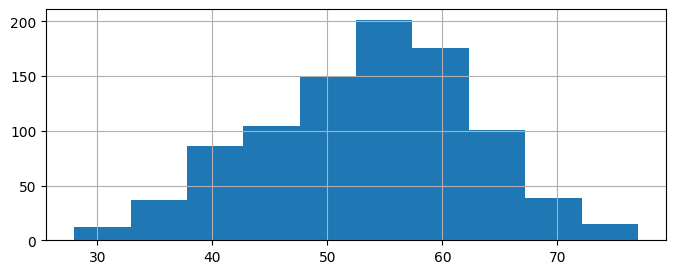

In [16]:
df.age.hist(figsize=(8,3))

In [17]:
df_pl["age"].plot.hist(bins=10)

:Histogram   [age]   (age_count)

In [18]:
df.age.dtype

double[pyarrow]

In [19]:
df_pl["age"].dtype

Float64

In [20]:
(df
 .astype({'age': 'int8[pyarrow]'})
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,0.0,4.0,127,333,1,1,154,0,0,?,?,?,1
916,62,1.0,1.0,?,139,0,1,?,?,?,?,?,?,0
917,55,1.0,4.0,122,223,1,1,100,0,0,?,?,6,2
918,58,1.0,4.0,?,385,1,2,?,?,?,?,?,?,0


In [21]:
(df_pl
 .cast({"age": pl.Int8})
 )

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
i8,f64,f64,str,str,str,str,str,str,str,str,str,str,i64
63,1.0,1.0,"""145.0""","""233.0""","""1.0""","""2.0""","""150.0""","""0.0""","""2.3""","""3.0""","""0.0""","""6.0""",0
67,1.0,4.0,"""160.0""","""286.0""","""0.0""","""2.0""","""108.0""","""1.0""","""1.5""","""2.0""","""3.0""","""3.0""",2
67,1.0,4.0,"""120.0""","""229.0""","""0.0""","""2.0""","""129.0""","""1.0""","""2.6""","""2.0""","""2.0""","""7.0""",1
37,1.0,3.0,"""130.0""","""250.0""","""0.0""","""0.0""","""187.0""","""0.0""","""3.5""","""3.0""","""0.0""","""3.0""",0
41,0.0,2.0,"""130.0""","""204.0""","""0.0""","""2.0""","""172.0""","""0.0""","""1.4""","""1.0""","""0.0""","""3.0""",0
56,1.0,2.0,"""120.0""","""236.0""","""0.0""","""0.0""","""178.0""","""0.0""","""0.8""","""1.0""","""0.0""","""3.0""",0
62,0.0,4.0,"""140.0""","""268.0""","""0.0""","""2.0""","""160.0""","""0.0""","""3.6""","""3.0""","""2.0""","""3.0""",3
57,0.0,4.0,"""120.0""","""354.0""","""0.0""","""0.0""","""163.0""","""1.0""","""0.6""","""1.0""","""0.0""","""3.0""",0
63,1.0,4.0,"""130.0""","""254.0""","""0.0""","""2.0""","""147.0""","""0.0""","""1.4""","""2.0""","""1.0""","""7.0""",2


## Sex

In [22]:
(df
 .astype({'age': 'int8[pyarrow]'})
 .sex
 .value_counts()
)

sex
1.0    726
0.0    194
Name: count, dtype: int64[pyarrow]

In [23]:
(df_pl
 .cast({"age": pl.Int8})
 ["sex"]
 .value_counts()
)

sex,count
f64,u32
1.0,726
0.0,194


In [24]:
# Expect an error here (for demonstration purposes)
# ArrowInvalid: Could not convert 'male' with type str: tried to convert to double

# (df
#  .astype({'age': 'int8[pyarrow]'})
#  .assign(sex=df.sex.replace({1.0: 'male', 0.0:'female'})) 
# )

In [25]:
(df
 .astype({'age': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}))
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67,male,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67,male,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37,male,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41,female,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,female,4.0,127,333,1,1,154,0,0,?,?,?,1
916,62,male,1.0,?,139,0,1,?,?,?,?,?,?,0
917,55,male,4.0,122,223,1,1,100,0,0,?,?,6,2
918,58,male,4.0,?,385,1,2,?,?,?,?,?,?,0


In [26]:
(df
 .astype({'age': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}))
 .sex
 .value_counts()
)

sex
male      726
female    194
Name: count, dtype: int64[pyarrow]

In [27]:
(df_pl
 .cast({"age": pl.Int8}) 
 .with_columns(
     sex = pl.col("sex").replace({1.0: "male", 0.0:"female"})
 )
 ["sex"]
 .value_counts()
)

sex,count
str,u32
"""male""",726
"""female""",194


## CP - Chest Pain
- Value 1: typical angina
- Value 2: atypical angina
- Value 3: non-anginal pain
- Value 4: asymptomatic

In [28]:
(df
 .astype({'age': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}))
 .cp
)

0      1.0
1      4.0
2      4.0
3      3.0
4      2.0
      ... 
915    4.0
916    1.0
917    4.0
918    4.0
919    2.0
Name: cp, Length: 920, dtype: double[pyarrow]

In [29]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}))
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,1,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67,male,4,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67,male,4,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37,male,3,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41,female,2,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,female,4,127,333,1,1,154,0,0,?,?,?,1
916,62,male,1,?,139,0,1,?,?,?,?,?,?,0
917,55,male,4,122,223,1,1,100,0,0,?,?,6,2
918,58,male,4,?,385,1,2,?,?,?,?,?,?,0


In [30]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8})
  .with_columns(
     sex = pl.col("sex").replace({1.0: "male", 0.0:"female"})
 )
)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
i8,str,i8,str,str,str,str,str,str,str,str,str,str,i64
63,"""male""",1,"""145.0""","""233.0""","""1.0""","""2.0""","""150.0""","""0.0""","""2.3""","""3.0""","""0.0""","""6.0""",0
67,"""male""",4,"""160.0""","""286.0""","""0.0""","""2.0""","""108.0""","""1.0""","""1.5""","""2.0""","""3.0""","""3.0""",2
67,"""male""",4,"""120.0""","""229.0""","""0.0""","""2.0""","""129.0""","""1.0""","""2.6""","""2.0""","""2.0""","""7.0""",1
37,"""male""",3,"""130.0""","""250.0""","""0.0""","""0.0""","""187.0""","""0.0""","""3.5""","""3.0""","""0.0""","""3.0""",0
41,"""female""",2,"""130.0""","""204.0""","""0.0""","""2.0""","""172.0""","""0.0""","""1.4""","""1.0""","""0.0""","""3.0""",0
56,"""male""",2,"""120.0""","""236.0""","""0.0""","""0.0""","""178.0""","""0.0""","""0.8""","""1.0""","""0.0""","""3.0""",0
62,"""female""",4,"""140.0""","""268.0""","""0.0""","""2.0""","""160.0""","""0.0""","""3.6""","""3.0""","""2.0""","""3.0""",3
57,"""female""",4,"""120.0""","""354.0""","""0.0""","""0.0""","""163.0""","""1.0""","""0.6""","""1.0""","""0.0""","""3.0""",0
63,"""male""",4,"""130.0""","""254.0""","""0.0""","""2.0""","""147.0""","""0.0""","""1.4""","""2.0""","""1.0""","""7.0""",2


## trestbps - Resting Blood Pressure

In [31]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}))
 .trestbps
 .describe()
)

count     920
unique    103
top       120
freq       94
Name: trestbps, dtype: object

In [32]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}))
 .trestbps
 .value_counts()
)

trestbps
120      94
130      79
140      70
?        59
110      40
         ..
108       1
129.0     1
113       1
92        1
127       1
Name: count, Length: 103, dtype: int64

In [33]:
# Expect an error (for demonstration purposes)
# ArrowInvalid: Could not convert '95' with type str: tried to convert to double

# (df
#  .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
#  .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
#          trestbps=df.trestbps.replace('?', None).astype('uint8[pyarrow]'))
# )

In [34]:
# Expect an error (for demonstration purposes)
# ArrowInvalid: Failed to parse string: '138.0' as a scalar of type uint8:

# (df
#  .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
#  .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
#          trestbps=df.trestbps.replace('?', None).astype('string[pyarrow]').astype('uint8[pyarrow]'))
# )

In [35]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=df.trestbps
         .replace('?', np.nan)
         .astype('string[pyarrow]')
         .astype('float[pyarrow]')
         .astype('int16[pyarrow]')
        ) 
)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,1,145,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67,male,4,160,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67,male,4,120,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37,male,3,130,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41,female,2,130,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,female,4,127,333,1,1,154,0,0,?,?,?,1
916,62,male,1,<NA>,139,0,1,?,?,?,?,?,?,0
917,55,male,4,122,223,1,1,100,0,0,?,?,6,2
918,58,male,4,<NA>,385,1,2,?,?,?,?,?,?,0


In [36]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=df.trestbps
         .replace('?', np.nan)
         .astype('string[pyarrow]')
         .astype('float[pyarrow]')
         .astype('int16[pyarrow]')
        )
 .trestbps
 .describe()
)

count    861.000000
mean     132.132404
std       19.066070
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: double[pyarrow]

In [37]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8})
  .with_columns(
     sex = pl.col("sex").replace({1.0: "male", 0.0:"female"}),
     trestbps = pl.col("trestbps").replace({"?":None}).cast(pl.Float64).cast(pl.Int16)
 )
)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
i8,str,i8,i16,str,str,str,str,str,str,str,str,str,i64
63,"""male""",1,145,"""233.0""","""1.0""","""2.0""","""150.0""","""0.0""","""2.3""","""3.0""","""0.0""","""6.0""",0
67,"""male""",4,160,"""286.0""","""0.0""","""2.0""","""108.0""","""1.0""","""1.5""","""2.0""","""3.0""","""3.0""",2
67,"""male""",4,120,"""229.0""","""0.0""","""2.0""","""129.0""","""1.0""","""2.6""","""2.0""","""2.0""","""7.0""",1
37,"""male""",3,130,"""250.0""","""0.0""","""0.0""","""187.0""","""0.0""","""3.5""","""3.0""","""0.0""","""3.0""",0
41,"""female""",2,130,"""204.0""","""0.0""","""2.0""","""172.0""","""0.0""","""1.4""","""1.0""","""0.0""","""3.0""",0
56,"""male""",2,120,"""236.0""","""0.0""","""0.0""","""178.0""","""0.0""","""0.8""","""1.0""","""0.0""","""3.0""",0
62,"""female""",4,140,"""268.0""","""0.0""","""2.0""","""160.0""","""0.0""","""3.6""","""3.0""","""2.0""","""3.0""",3
57,"""female""",4,120,"""354.0""","""0.0""","""0.0""","""163.0""","""1.0""","""0.6""","""1.0""","""0.0""","""3.0""",0
63,"""male""",4,130,"""254.0""","""0.0""","""2.0""","""147.0""","""0.0""","""1.4""","""2.0""","""1.0""","""7.0""",2


## chol - serum cholestoral (mg/dl)

In [38]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=df.trestbps
         .replace('?', np.nan)
         .astype('string[pyarrow]')
         .astype('float[pyarrow]')
         .astype('int16[pyarrow]')
        )
 .chol
 .describe()
)

count     920
unique    336
top         0
freq      123
Name: chol, dtype: int64

In [39]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=df.trestbps
         .replace('?', np.nan)
         .astype('string[pyarrow]')
         .astype('float[pyarrow]')
         .astype('int16[pyarrow]')
        )
 .chol
 .value_counts()
)

chol
0        123
0         49
?         30
220        7
216        7
        ... 
187        1
141.0      1
328        1
168        1
385        1
Name: count, Length: 336, dtype: int64

In [40]:
def remove_question(
    df: pd.DataFrame, col: str, dtype: str = "int8[pyarrow]"
) -> pd.DataFrame:
    return (
        df[col]
        .replace("?", np.nan)
        .astype("string[pyarrow]")
        .astype("float[pyarrow]")
        .astype(dtype)
    )

In [41]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]')
        )
 .chol
 .value_counts()
)

chol
0      172
254     10
220     10
204      9
211      9
      ... 
165      1
337      1
333      1
139      1
385      1
Name: count, Length: 217, dtype: int64[pyarrow]

<Axes: >

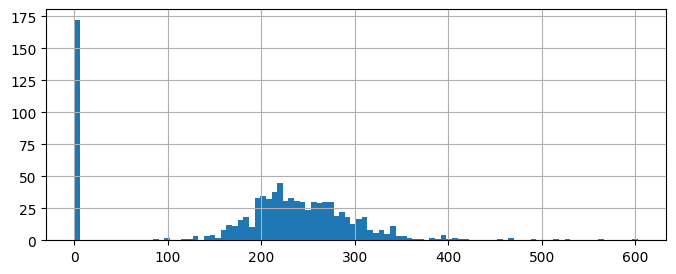

In [42]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]')
        )
 .chol
 .hist(bins=100, figsize=(8,3))
)

In [43]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]')
        )
 .chol
 .isna()
 .sum()
)

30

In [44]:
def remove_question_pl(
    df: pl.Expr, dtype: str = pl.Int8
) -> pl.DataFrame:
    return (
        df
        .replace("?", None)
        .cast(pl.Float64)
        .cast(dtype)
    )

In [45]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16)
 )
 ["chol"]
 .is_null()
 .sum()
)

30

In [46]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16)
 )
 ["chol"]
 .plot.hist(bins=100)
)

:Histogram   [chol]   (chol_count)

## fbs - Fasting blood sugar (> 120 mg/dl)

In [47]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]')
        )
 .fbs
 .describe()
)

count     920
unique      5
top         0
freq      434
Name: fbs, dtype: object

In [48]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]')
        )
 .fbs
 .value_counts()
)

fbs
0      434
0.0    258
1       93
?       90
1.0     45
Name: count, dtype: int64

In [49]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]')         
        )
 .fbs
 .value_counts(dropna=False)
)

fbs
False    692
True     138
<NA>      90
Name: count, dtype: int64[pyarrow]

In [50]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
     fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean)
 )
 ["fbs"]
 .value_counts()
)

fbs,count
bool,u32
true,138
null,90
false,692


## restecg - resting electrocardiographic results
- Value 0: normal
- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
          elevation or depression of > 0.05 mV)
- Value 2: showing probable or definite left ventricular hypertrophy
          by Estes' criteria

In [51]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]')         
        )
 .restecg
 .value_counts()
)

restecg
0      320
0.0    231
2.0    175
1.0     97
1       82
2       13
?        2
Name: count, dtype: int64

In [52]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]')         
        )
 .restecg
 .value_counts()
)

restecg
0    551
2    188
1    179
Name: count, dtype: int64[pyarrow]

In [53]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
     fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
     restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8)
 )
 ["restecg"]
 .value_counts(sort=True)
)

restecg,count
i8,u32
0,551
2,188
1,179
null,2


## thalach - maximum heart rate achieved

In [54]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]')         
        )
 .thalach
 .value_counts()
)

thalach
?        55
150      36
140      35
120      32
130      26
         ..
95.0      1
179       1
192.0     1
127.0     1
151       1
Name: count, Length: 198, dtype: int64

In [55]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
         
        )
 .thalach
 .value_counts()
)

thalach
150    43
140    41
120    35
130    30
160    26
       ..
78      1
67      1
107     1
69      1
73      1
Name: count, Length: 119, dtype: int64[pyarrow]

In [56]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
     fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
     restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8),
     thalach=pl.col("thalach").pipe(remove_question_pl, pl.Int16)
 )
 ["thalach"]
 .value_counts(sort=True)
)

thalach,count
i16,u32
null,55
150,43
140,41
120,35
130,30
160,26
110,21
125,20
170,20


## exang - exercise induced angina 1 - yes 0 - no

In [57]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
         
        )
 .exang
 .value_counts()
)

exang
0      324
1      238
0.0    204
1.0     99
?       55
Name: count, dtype: int64

In [58]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
         
         
        )
 .exang
 .value_counts()
)

exang
False    528
True     337
Name: count, dtype: int64[pyarrow]

In [59]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
     fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
     restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8),
     thalach=pl.col("thalach").pipe(remove_question_pl, pl.Int16),
     exang=pl.col("exang").pipe(remove_question_pl, pl.Boolean)
 )
 ["exang"]
 .value_counts(sort=True)
)

exang,count
bool,u32
false,528
true,337
null,55


## oldpeak - ST depression induced by exercise relative to rest

In [60]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
         
         
        )
 .oldpeak
 .value_counts()
)

oldpeak
0.0     288
0        82
?        62
1.0      55
2.0      40
       ... 
-.1       1
4.4       1
5.0       1
-1.5      1
0.8       1
Name: count, Length: 82, dtype: int64

In [61]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),           
        )
 .oldpeak
 .value_counts()
)

oldpeak
 0.0    370
 1.0     83
 2.0     76
 1.5     48
 3.0     28
 0.5     19
 1.2     17
 2.5     16
 1.4     15
 0.8     15
 0.6     14
 1.6     14
 0.2     14
 1.8     12
 0.4     10
 0.1      9
 4.0      8
 2.6      7
 2.8      7
 1.3      5
 2.2      5
 1.9      5
 0.7      5
 0.3      5
 3.6      4
 2.4      4
 0.9      4
 1.1      4
 3.4      3
 2.3      2
 3.5      2
 3.2      2
 2.1      2
 4.2      2
-1.0      2
 1.7      2
-0.5      2
 3.1      1
 6.2      1
 5.6      1
 2.9      1
 3.8      1
 4.4      1
 5.0      1
-1.1      1
-1.5      1
-0.1      1
-2.6      1
-0.7      1
-2.0      1
-0.8      1
-0.9      1
 3.7      1
Name: count, dtype: int64[pyarrow]

In [62]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
     fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
     restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8),
     thalach=pl.col("thalach").pipe(remove_question_pl, pl.Int16),
     exang=pl.col("exang").pipe(remove_question_pl, pl.Boolean),
     oldpeak=pl.col("oldpeak").pipe(remove_question_pl, pl.Float64)
 )
 ["oldpeak"]
 .value_counts(sort=True)
)

oldpeak,count
f64,u32
0.0,370
1.0,83
2.0,76
null,62
1.5,48
3.0,28
0.5,19
1.2,17
2.5,16


## slope - the slope of the peak exercise ST segment
- Value 1: upsloping
- Value 2: flat
- Value 3: downsloping

In [63]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),           
        )
 .slope
 .value_counts()
)

slope
?      309
2      205
1.0    142
2.0    140
1       61
3       42
3.0     21
Name: count, dtype: int64

In [64]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        )
 .slope
 .value_counts()
)

slope
2    345
1    203
3     63
Name: count, dtype: int64[pyarrow]

In [65]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
     fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
     restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8),
     thalach=pl.col("thalach").pipe(remove_question_pl, pl.Int16),
     exang=pl.col("exang").pipe(remove_question_pl, pl.Boolean),
     oldpeak=pl.col("oldpeak").pipe(remove_question_pl, pl.Float64),
     slope=pl.col("slope").pipe(remove_question_pl, pl.Int8)
 )
 ["slope"]
 .value_counts(sort=True)
)

slope,count
i8,u32
2,345
null,309
1,203
3,63


## ca - number of major vessels (0-3) colored by flouroscopy

In [66]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        )
 .ca
 .value_counts()
)

ca
?      611
0.0    176
1.0     65
2.0     38
3.0     20
0        5
2        3
1        2
Name: count, dtype: int64[pyarrow]

In [67]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        ca=lambda df_: remove_question(df_, 
                            'ca', dtype='int8[pyarrow]'),
        )
 .ca
 .value_counts()
)

ca
0    181
1     67
2     41
3     20
Name: count, dtype: int64[pyarrow]

In [82]:
(df_pl
 .cast({"age": pl.Int8, "cp": pl.Int8}).with_columns(
     sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
     trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
     chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
     fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
     restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8),
     thalach=pl.col("thalach").pipe(remove_question_pl, pl.Int16),
     exang=pl.col("exang").pipe(remove_question_pl, pl.Boolean),
     oldpeak=pl.col("oldpeak").pipe(remove_question_pl, pl.Float64),
     slope=pl.col("slope").pipe(remove_question_pl, pl.Int8),
     ca=pl.col("ca").pipe(remove_question_pl, pl.Int8)
 )
 ["ca"]
 .value_counts(sort=True)
)

ca,count
i8,u32
null,611
0,181
1,67
2,41
3,20


## thal 

- 3 = normal; 6 = fixed defect; 7 = reversable defect

In [83]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        ca=lambda df_: remove_question(df_, 
                            'ca', dtype='int8[pyarrow]'),
        )
 .thal
 .value_counts()
)

thal
?      486
3.0    166
7.0    117
7       75
3       30
6       28
6.0     18
Name: count, dtype: int64[pyarrow]

In [84]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        ca=lambda df_: remove_question(df_, 
                            'ca', dtype='int8[pyarrow]'),
        thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                            '7.0': '7', '6.0': '6'})
                             .replace({'?': 'missing', '3': 'normal',
                                       '6': 'fixed', '7': 'reversible'}))
        )
 .thal
 .value_counts()
)

thal
missing       486
normal        196
reversible    192
fixed          46
Name: count, dtype: int64[pyarrow]

In [90]:
(
    df_pl.cast({"age": pl.Int8, "cp": pl.Int8})
    .with_columns(
        sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
        trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
        chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
        fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
        restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8),
        thalach=pl.col("thalach").pipe(remove_question_pl, pl.Int16),
        exang=pl.col("exang").pipe(remove_question_pl, pl.Boolean),
        oldpeak=pl.col("oldpeak").pipe(remove_question_pl, pl.Float64),
        slope=pl.col("slope").pipe(remove_question_pl, pl.Int8),
        ca=pl.col("ca").pipe(remove_question_pl, pl.Int8),
        thal=pl.col("thal").pipe(remove_question_pl, pl.Int8)
         .replace({3: "normal", 6: "fixed", 7: "reversible"}),
    )
    ["thal"]
    .value_counts(sort=True)
)

thal,count
str,u32
null,486
"""normal""",196
"""reversible""",192
"""fixed""",46


## num
: diagnosis of heart disease (angiographic disease status)
- Value 0: < 50% diameter narrowing
- Value 1: > 50% diameter narrowing
(in any major vessel: attributes 59 through 68 are vessels)

In [91]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        ca=lambda df_: remove_question(df_, 
                            'ca', dtype='int8[pyarrow]'),
        thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                            '7.0': '7', '6.0': '6'})
                             .replace({'?': 'missing', '3': 'normal',
                                       '6': 'fixed', '7': 'reversible'}))
        )
 .num
 .value_counts()
)

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64[pyarrow]

In [92]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        ca=lambda df_: remove_question(df_, 
                            'ca', dtype='int8[pyarrow]'),
        thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                            '7.0': '7', '6.0': '6'})
                             .replace({'?': 'missing', '3': 'normal',
                                       '6': 'fixed', '7': 'reversible'}))
        )
 .num
 .dtype
)

int64[pyarrow]

In [93]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]',
         'num': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        ca=lambda df_: remove_question(df_, 
                            'ca', dtype='int8[pyarrow]'),
        thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                            '7.0': '7', '6.0': '6'})
                             .replace({'?': 'missing', '3': 'normal',
                                       '6': 'fixed', '7': 'reversible'}))
        )
 .num
 .dtype
)

int8[pyarrow]

In [95]:
(
    df_pl.cast({"age": pl.Int8, "cp": pl.Int8, "num": pl.Int8})
    .with_columns(
        sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
        trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
        chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
        fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
        restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8),
        thalach=pl.col("thalach").pipe(remove_question_pl, pl.Int16),
        exang=pl.col("exang").pipe(remove_question_pl, pl.Boolean),
        oldpeak=pl.col("oldpeak").pipe(remove_question_pl, pl.Float64),
        slope=pl.col("slope").pipe(remove_question_pl, pl.Int8),
        ca=pl.col("ca").pipe(remove_question_pl, pl.Int8),
        thal=pl.col("thal")
        .pipe(remove_question_pl, pl.Int8)
        .replace({3: "normal", 6: "fixed", 7: "reversible"}),
    )
    ["num"]
    .dtype
)

Int8

## Memory Usage

In [96]:
df.memory_usage(deep=True).sum()

357932

In [97]:
df_pl.estimated_size()

123936

In [99]:
(df
 .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]',
         'num': 'int8[pyarrow]'})
 .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
        trestbps=lambda df_: remove_question(df_, 
                            'trestbps', dtype='int16[pyarrow]'),
        chol=lambda df_: remove_question(df_, 
                            'chol', dtype='int16[pyarrow]'),
        fbs=lambda df_: remove_question(df_, 
                            'fbs', dtype='bool[pyarrow]'),         
        restecg=lambda df_: remove_question(df_, 
                            'restecg', dtype='int8[pyarrow]'),
        thalach=lambda df_: remove_question(df_, 
                            'thalach', dtype='int16[pyarrow]'),
        exang=lambda df_: remove_question(df_, 
                            'exang', dtype='bool[pyarrow]'),         
        oldpeak=lambda df_: remove_question(df_, 
                            'oldpeak', dtype='float[pyarrow]'),   
        slope=lambda df_: remove_question(df_, 
                            'slope', dtype='int8[pyarrow]'),
        ca=lambda df_: remove_question(df_, 
                            'ca', dtype='int8[pyarrow]'),
        thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                            '7.0': '7', '6.0': '6'})
                             .replace({'?': 'missing', '3': 'normal',
                                       '6': 'fixed', '7': 'reversible'}))
        )
 .memory_usage(deep=True)
 .sum()
)

34618

In [100]:
357_932 / 34_618

10.33947657288116

In [101]:
(
    df_pl.cast({"age": pl.Int8, "cp": pl.Int8, "num": pl.Int8})
    .with_columns(
        sex=pl.col("sex").replace({1.0: "male", 0.0: "female"}),
        trestbps=pl.col("trestbps").pipe(remove_question_pl, pl.Int16),
        chol=pl.col("chol").pipe(remove_question_pl, pl.Int16),
        fbs=pl.col("fbs").pipe(remove_question_pl, pl.Boolean),
        restecg=pl.col("restecg").pipe(remove_question_pl, pl.Int8),
        thalach=pl.col("thalach").pipe(remove_question_pl, pl.Int16),
        exang=pl.col("exang").pipe(remove_question_pl, pl.Boolean),
        oldpeak=pl.col("oldpeak").pipe(remove_question_pl, pl.Float64),
        slope=pl.col("slope").pipe(remove_question_pl, pl.Int8),
        ca=pl.col("ca").pipe(remove_question_pl, pl.Int8),
        thal=pl.col("thal")
        .pipe(remove_question_pl, pl.Int8)
        .replace({3: "normal", 6: "fixed", 7: "reversible"}),
    )
    .estimated_size()
)

42396

In [103]:
123_936 / 42_396

2.9232946504387205

## Make a Function

In [104]:
import pandas as pd
import numpy as np

import glob

names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

files = glob.glob('data/processed*.data')
df = pd.concat([pd.read_csv(f, sep=',',names=names,
                           dtype_backend='pyarrow', engine='pyarrow')
                for f in files], axis='index', ignore_index=True)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54.0,0.0,4.0,127,333,1,1,154,0,0,?,?,?,1
916,62.0,1.0,1.0,?,139,0,1,?,?,?,?,?,?,0
917,55.0,1.0,4.0,122,223,1,1,100,0,0,?,?,6,2
918,58.0,1.0,4.0,?,385,1,2,?,?,?,?,?,?,0


In [105]:
def remove_question(df, col, dtype='int8[pyarrow]'):
    res = (df
            [col]
            .replace('?', np.nan)
            .astype('string[pyarrow]')
            .astype('float[pyarrow]')
          )
    if dtype == 'float[pyarrow]':
        return res
    else:
        return (res
            .astype(dtype)   
           )

def tweak_heart(df):
    return (df
     .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]',
             'num': 'int8[pyarrow]'})
     .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
            trestbps=lambda df_: remove_question(df_, 
                                'trestbps', dtype='int16[pyarrow]'),
            chol=lambda df_: remove_question(df_, 
                                'chol', dtype='int16[pyarrow]'),
            fbs=lambda df_: remove_question(df_, 
                                'fbs', dtype='bool[pyarrow]'),         
            restecg=lambda df_: remove_question(df_, 
                                'restecg', dtype='int8[pyarrow]'),
            thalach=lambda df_: remove_question(df_, 
                                'thalach', dtype='int16[pyarrow]'),
            exang=lambda df_: remove_question(df_, 
                                'exang', dtype='bool[pyarrow]'),         
            oldpeak=lambda df_: remove_question(df_, 
                                'oldpeak', dtype='float[pyarrow]'),   
            slope=lambda df_: remove_question(df_, 
                                'slope', dtype='int8[pyarrow]'),
            ca=lambda df_: remove_question(df_, 
                                'ca', dtype='int8[pyarrow]'),
            thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                                '7.0': '7', '6.0': '6'})
                                 .replace({'?': 'missing', '3': 'normal',
                                           '6': 'fixed', '7': 'reversible'}))
            )
    )

tweak_heart(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,1,145,233,True,2,150,False,2.3,3,0,fixed,0
1,67,male,4,160,286,False,2,108,True,1.5,2,3,normal,2
2,67,male,4,120,229,False,2,129,True,2.6,2,2,reversible,1
3,37,male,3,130,250,False,0,187,False,3.5,3,0,normal,0
4,41,female,2,130,204,False,2,172,False,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,female,4,127,333,True,1,154,False,0.0,<NA>,<NA>,missing,1
916,62,male,1,<NA>,139,False,1,<NA>,<NA>,<NA>,<NA>,<NA>,missing,0
917,55,male,4,122,223,True,1,100,False,0.0,<NA>,<NA>,fixed,2
918,58,male,4,<NA>,385,True,2,<NA>,<NA>,<NA>,<NA>,<NA>,missing,0


In [78]:
# This doesn't work!
def remove_question(df, col, dtype='int8[pyarrow]'):
    res = (df
            [col]
            .replace('?', np.nan)
            .astype('string[pyarrow]')
            .astype('float[pyarrow]')
          )
    if dtype == 'float[pyarrow]':
        return res
    else:
        return (res
            .astype(dtype)   
           )

types = {'trestbps':'int16[pyarrow]',
         'chol':'int16[pyarrow]',
         'fbs':'bool[pyarrow]',         
         'restecg':'int8[pyarrow]',                  
         'thalach':'int16[pyarrow]',                           
         'exang':'bool[pyarrow]', 
         'oldpeak':'float[pyarrow]',          
         'slope':'int8[pyarrow]',
         'ca':'int8[pyarrow]',         
        }
    
def tweak_heart(df):
    return (df
     .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]',
             'num': 'int8[pyarrow]'})
     .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
            **{col: lambda df_: remove_question(df_, col, dtype)
              for col, dtype in types.items()},
            thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                                '7.0': '7', '6.0': '6'})
                                 .replace({'?': 'missing', '3': 'normal',
                                           '6': 'fixed', '7': 'reversible'}))
            )
    )

tweak_heart(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,1,0,0,0,0,0,0,0,0,0,fixed,0
1,67,male,4,3,3,3,3,3,3,3,3,3,normal,2
2,67,male,4,2,2,2,2,2,2,2,2,2,reversible,1
3,37,male,3,0,0,0,0,0,0,0,0,0,normal,0
4,41,female,2,0,0,0,0,0,0,0,0,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,female,4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,missing,1
916,62,male,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,missing,0
917,55,male,4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,fixed,2
918,58,male,4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,missing,0


In [106]:
# Fix by adding default params to lambda
def remove_question(df, col, dtype='int8[pyarrow]'):
    res = (df
            [col]
            .replace('?', np.nan)
            .astype('string[pyarrow]')
            .astype('float[pyarrow]')
          )
    if dtype == 'float[pyarrow]':
        return res
    else:
        return (res
            .astype(dtype)   
           )

types = {'trestbps':'int16[pyarrow]',
         'chol':'int16[pyarrow]',
         'fbs':'bool[pyarrow]',         
         'restecg':'int8[pyarrow]',                  
         'thalach':'int16[pyarrow]',                           
         'exang':'bool[pyarrow]', 
         'oldpeak':'float[pyarrow]',          
         'slope':'int8[pyarrow]',
         'ca':'int8[pyarrow]',         
        }
    
def tweak_heart(df):
    return (df
     .astype({'age': 'int8[pyarrow]', 'cp': 'int8[pyarrow]',
             'num': 'int8[pyarrow]'})
     .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
            **{col: (lambda df2_, col=col, dtype=dtype: remove_question(df2_, col, dtype))
               for col, dtype in types.items()},
            thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                                '7.0': '7', '6.0': '6'})
                                 .replace({'?': 'missing', '3': 'normal',
                                           '6': 'fixed', '7': 'reversible'}))
            )
    )

tweak_heart(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,1,145,233,True,2,150,False,2.3,3,0,fixed,0
1,67,male,4,160,286,False,2,108,True,1.5,2,3,normal,2
2,67,male,4,120,229,False,2,129,True,2.6,2,2,reversible,1
3,37,male,3,130,250,False,0,187,False,3.5,3,0,normal,0
4,41,female,2,130,204,False,2,172,False,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,female,4,127,333,True,1,154,False,0.0,<NA>,<NA>,missing,1
916,62,male,1,<NA>,139,False,1,<NA>,<NA>,<NA>,<NA>,<NA>,missing,0
917,55,male,4,122,223,True,1,100,False,0.0,<NA>,<NA>,fixed,2
918,58,male,4,<NA>,385,True,2,<NA>,<NA>,<NA>,<NA>,<NA>,missing,0


In [107]:
# Convert ?'s at once
types = {'trestbps':'int16[pyarrow]',
         'chol':'int16[pyarrow]',
         'fbs':'bool[pyarrow]',         
         'restecg':'int8[pyarrow]',                  
         'thalach':'int16[pyarrow]',                           
         'exang':'bool[pyarrow]', 
         'oldpeak':'float[pyarrow]',          
         'slope':'int8[pyarrow]',
         'ca':'int8[pyarrow]',         
        }
    
def tweak_heart(df):
    return (df
     .astype({'age': 'int8[pyarrow]', 'cp': 'inst8[pyarrow]',
             'num': 'int8[pyarrow]'})
     .assign(sex=df.sex.astype('string[pyarrow]').replace({'1.0': 'male', '0.0':'female'}),
            #**{col: (lambda df2_, col=col, dtype=dtype: remove_question(df2_, col, dtype))
            #   for col, dtype in types.items()},
            **(df.loc[:, list(types)].replace('?', np.nan).astype('string[pyarrow]').astype('float[pyarrow]')),
            thal=lambda df_: (df_.thal.replace({'3.0': '3',
                                                '7.0': '7', '6.0': '6'})
                                 .replace({'?': 'missing', '3': 'normal',
                                           '6': 'fixed', '7': 'reversible'}))
            )
     .astype(types)
    )

tweak_heart(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,1,145,233,True,2,150,False,2.3,3,0,fixed,0
1,67,male,4,160,286,False,2,108,True,1.5,2,3,normal,2
2,67,male,4,120,229,False,2,129,True,2.6,2,2,reversible,1
3,37,male,3,130,250,False,0,187,False,3.5,3,0,normal,0
4,41,female,2,130,204,False,2,172,False,1.4,1,0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,female,4,127,333,True,1,154,False,0.0,<NA>,<NA>,missing,1
916,62,male,1,<NA>,139,False,1,<NA>,<NA>,<NA>,<NA>,<NA>,missing,0
917,55,male,4,122,223,True,1,100,False,0.0,<NA>,<NA>,fixed,2
918,58,male,4,<NA>,385,True,2,<NA>,<NA>,<NA>,<NA>,<NA>,missing,0
